In [ ]:
!pip install albumentations

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from albumentations.pytorch import ToTensorV2
import albumentations as A
import cv2
import random
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import train_test_split
import glob
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DRIVE_PATH = "/content/drive/MyDrive"
CHECKPOINT_PATH = os.path.join(DRIVE_PATH, '35th_epoch.pth')
STATE_PATH = os.path.join(DRIVE_PATH, 'cow_identification_state.json')

# --- CONFIGURATION ---
config = {
    "img_size": 224,
    "batch_size": 32,
    "embedding_dim": 128,
    "learning_rate": 0.0001,
    "total_epochs": 25,
    "freeze_epochs": 5,
    "triplet_margin": 1.5,
    "train_root": os.path.join(DRIVE_PATH, 'train'),
    "val_root": os.path.join(DRIVE_PATH, 'val'),
    "test_root": os.path.join(DRIVE_PATH, 'test')
}

# --- DATA PREPARATION ---
def save_state(state):
    with open(STATE_PATH, 'w') as f:
        json.dump(state, f)
    print(f"✅ Data split state saved to {STATE_PATH}")

def load_state():
    if os.path.exists(STATE_PATH):
        with open(STATE_PATH, 'r') as f:
            state = json.load(f)
        print(f"🔁 Data split state loaded from {STATE_PATH}")
        return state['known_train_paths'], state['known_val_paths'], state['test_paths'], state['known_classes'], state['unknown_classes']
    return None, None, None, None, None

def create_data_splits(config, known_ratio=2/3, random_state=42):
    known_train_paths_state, known_val_paths_state, test_paths_state, known_classes_state, unknown_classes_state = load_state()

    if known_train_paths_state:
        return known_train_paths_state, known_val_paths_state, test_paths_state, known_classes_state, unknown_classes_state

    # 1. Load all paths from the three folders
    all_train_paths = glob.glob(os.path.join(config['train_root'], '*', '*.jpg'))
    all_val_paths = glob.glob(os.path.join(config['val_root'], '*', '*.jpg'))
    all_test_paths = glob.glob(os.path.join(config['test_root'], '*', '*.jpg'))

    # 2. Split train classes into known (2/3) and unknown (1/3)
    unique_train_labels = list(set([p.split(os.sep)[-2] for p in all_train_paths]))
    known_classes, unknown_classes = train_test_split(unique_train_labels, test_size=1-known_ratio, random_state=random_state)

    # 3. Create the actual path lists
    known_train_paths = [p for p in all_train_paths if p.split(os.sep)[-2] in known_classes]

    # 4. Use val and test folders as-is
    known_val_paths = all_val_paths
    test_paths = all_test_paths

    print(f"Total train classes: {len(unique_train_labels)}")
    print(f"Known classes (2/3 of train): {len(known_classes)}")
    print(f"Unknown classes (1/3 of train): {len(unknown_classes)}")
    print(f"Known train images (for training): {len(known_train_paths)}")
    print(f"Validation images: {len(known_val_paths)}")
    print(f"Test images: {len(test_paths)}")

    # 5. Save the state for consistency
    state_to_save = {
        'known_train_paths': known_train_paths,
        'known_val_paths': known_val_paths,
        'test_paths': test_paths,
        'known_classes': known_classes,
        'unknown_classes': unknown_classes
    }
    save_state(state_to_save)

    return known_train_paths, known_val_paths, test_paths, known_classes, unknown_classes

known_train_paths, known_val_paths, test_paths, known_classes, unknown_classes = create_data_splits(config)


# --- DATASET & DATALOADER ---
class TripletDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.transform = transform
        self.label_to_images = {}
        for p in image_paths:
            label = p.split(os.sep)[-2]
            self.label_to_images.setdefault(label, []).append(p)
        self.labels = list(self.label_to_images.keys())

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        anchor_label = random.choice(self.labels)
        negative_label = random.choice([l for l in self.labels if l != anchor_label])
        anchor_path = random.choice(self.label_to_images[anchor_label])
        positive_path = random.choice(self.label_to_images[anchor_label])
        negative_path = random.choice(self.label_to_images[negative_label])

        def load(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return self.transform(image=img)['image']

        return load(anchor_path), load(positive_path), load(negative_path)

transform_eval = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.Normalize(),
    ToTensorV2()
])
val_dataset = TripletDataset(known_val_paths, transform=transform_eval)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

transform_train = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.HorizontalFlip(p=0.5), # Flip horizontally with a 50% probability
    A.RandomRotate90(p=0.5), # Randomly rotate by 90 degrees
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), # Randomly change color properties
    A.Normalize(),
    ToTensorV2()
])
train_dataset = TripletDataset(known_train_paths, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)


# --- MODEL & LOSS FUNCTIONS ---
class Encoder(nn.Module):
    def __init__(self, embedding_dim, freeze_backbone=True):
        super().__init__()
        weights = EfficientNet_B5_Weights.IMAGENET1K_V1
        self.backbone = efficientnet_b5(weights=weights)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, embedding_dim)
        )
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

def triplet_loss(anchor, positive, negative, margin=config['triplet_margin']):
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    loss = torch.relu(pos_dist - neg_dist + margin)
    return loss.mean()


# --- HELPER FUNCTIONS FOR CHECKPOINTING ---
def save_checkpoint(model, optimizer, epoch, freeze_backbone, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'freeze_backbone': freeze_backbone,
    }, path)
    print(f"💾 Checkpoint saved after epoch {epoch}")

def load_checkpoint(model_class, optimizer_class, embedding_dim, lr, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    freeze = checkpoint.get('freeze_backbone', True)

    model = model_class(embedding_dim=embedding_dim, freeze_backbone=freeze).to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])

    if freeze:
        optimizer = optimizer_class(model.head.parameters(), lr=lr)
    else:
        for p in model.backbone.parameters():
            p.requires_grad = True
        optimizer = optimizer_class(model.parameters(), lr=lr * 0.1)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint['epoch']
    print(f"🔁 Resumed from epoch {start_epoch} (freeze_backbone={freeze})")
    return model, optimizer, start_epoch, freeze

def evaluate_val_loss(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for anc, pos, neg in val_loader:
            anc, pos, neg = anc.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
            e_anc = model(anc)
            e_pos = model(pos)
            e_neg = model(neg)
            loss = triplet_loss(e_anc, e_pos, e_neg)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    model.train()
    return avg_loss

🔁 Data split state loaded from /content/drive/MyDrive/cow_identification_state.json


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train_model(model_class, train_loader, val_loader, embedding_dim, lr, checkpoint_path, total_epochs, freeze_epochs):

    start_epoch = 0
    eval_frequency = 5

    if os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, freeze_backbone = load_checkpoint(
            model_class=model_class,
            optimizer_class=optim.Adam,
            embedding_dim=embedding_dim,
            lr=lr,
            checkpoint_path=checkpoint_path,
        )
        # Update the learning rate for the unfreeze phase if needed
        if not freeze_backbone:
            for g in optimizer.param_groups:
                g['lr'] = lr * 0.1
    else:
        model = model_class(embedding_dim=embedding_dim, freeze_backbone=True).to(DEVICE)
        optimizer = optim.Adam(model.head.parameters(), lr=lr)
        freeze_backbone = True
        print("🚀 Starting training from scratch...")

    model.train()
    # تنظیمات نهایی برای کاهش مصرف حافظه
    unfreeze_batch_size = 4
    accumulation_steps = 4
    unfreeze_train_loader = DataLoader(train_loader.dataset, batch_size=unfreeze_batch_size, shuffle=True, num_workers=4)

    print(f"Starting training for {total_epochs} epochs from epoch {start_epoch+1}")

    current_loader = train_loader
    for epoch in range(start_epoch, total_epochs):
        print(f"Epoch {epoch+1}/{total_epochs} - Freeze backbone: {freeze_backbone}")

        # Switch to the smaller batch size for the unfreeze phase
        if not freeze_backbone:
            current_loader = unfreeze_train_loader

        total_loss = 0
        optimizer.zero_grad()

        for i, (anc, pos, neg) in enumerate(tqdm(current_loader)):
            anc, pos, neg = anc.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)

            e_anc = model(anc)
            e_pos = model(pos)
            e_neg = model(neg)
            loss = triplet_loss(e_anc, e_pos, e_neg)

            loss = loss / accumulation_steps
            loss.backward()

            total_loss += loss.item() * accumulation_steps

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        avg_train_loss = total_loss / len(current_loader)
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}")

        if (epoch + 1) % eval_frequency == 0 or (epoch + 1) == total_epochs:
            val_loss = evaluate_val_loss(model, val_loader)
        save_checkpoint(model, optimizer, epoch+1, freeze_backbone, checkpoint_path)


        if freeze_backbone and (epoch + 1) >= freeze_epochs:
            print("🔓 Unfreezing backbone and updating optimizer...")
            # This part is crucial for memory management
            torch.cuda.empty_cache()

            freeze_backbone = False
            for p in model.backbone.parameters():
                p.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=lr * 0.1)

    print("✅ Training complete")
    return model

In [ ]:
# Start the training process
model = train_model(
    model_class=Encoder,
    train_loader=train_loader,
    val_loader=val_loader,
    embedding_dim=config['embedding_dim'],
    lr=config['learning_rate'],
    checkpoint_path=CHECKPOINT_PATH,
    total_epochs=35,
    freeze_epochs=10,
)
#config['total_epochs']

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:03<00:00, 37.0MB/s]


ValueError: loaded state dict contains a parameter group that doesn't match the size of optimizer's group

In [ ]:
import torch
import os

# Define the path to your checkpoint file
CHECKPOINT_FILE_PATH = os.path.join(DRIVE_PATH, '35th_epoch.pth')

# 1. Instantiate the model with its correct architecture
model = Encoder(embedding_dim=config['embedding_dim'])

# 2. Check if the checkpoint file exists
if os.path.exists(CHECKPOINT_FILE_PATH):
    print(f"✅ Loading model from {CHECKPOINT_FILE_PATH}")

    # Load the entire checkpoint
    checkpoint = torch.load(CHECKPOINT_FILE_PATH)

    # Load ONLY the model's weights (state_dict)
    model.load_state_dict(checkpoint['model_state_dict'])

    print("✅ Model loaded successfully for evaluation.")
else:
    print(f"❌ Error: Checkpoint file not found at {CHECKPOINT_FILE_PATH}")

# Set the model to evaluation mode
model.eval()

✅ Loading model from /content/drive/MyDrive/35th_epoch.pth


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
import torch
import os

# Define the path to your checkpoint file
CHECKPOINT_FILE_PATH = os.path.join(DRIVE_PATH, '35th_epoch.pth')

# 1. Instantiate the model with its correct architecture
model = Encoder(embedding_dim=config['embedding_dim'])

# 2. Check if the checkpoint file exists
if os.path.exists(CHECKPOINT_FILE_PATH):
    print(f"✅ Loading model from {CHECKPOINT_FILE_PATH}")

    # Load the entire checkpoint, mapping all tensors to the CPU
    checkpoint = torch.load(CHECKPOINT_FILE_PATH, map_location=torch.device('cpu'))

    # Load ONLY the model's weights (state_dict)
    model.load_state_dict(checkpoint['model_state_dict'])

    print("✅ Model loaded successfully for evaluation.")
else:
    print(f"❌ Error: Checkpoint file not found at {CHECKPOINT_FILE_PATH}")

# Set the model to evaluation mode
model.eval()

✅ Loading model from /content/drive/MyDrive/35th_epoch.pth
✅ Model loaded successfully for evaluation.


Encoder(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activatio

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2

class FeatureDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        # Extract label from the path
        label = image_path.split(os.sep)[-2]

        return image, label, image_path

In [ ]:
def extract_and_save_embeddings(model, image_paths, transform, output_path, batch_size=None):
    if os.path.exists(output_path):
        print(f"✅ Loading embeddings from {output_path}")
        data = torch.load(output_path)
        return data['embeddings'], data['labels'], data['paths']

    print(f"⏳ Extracting embeddings and saving to {output_path}")
    dataset = FeatureDataset(image_paths, transform)

    # Use the passed batch_size, or fall back to the default config
    current_batch_size = batch_size if batch_size is not None else config['batch_size']

    loader = DataLoader(dataset, batch_size=current_batch_size, shuffle=False)
    model.eval()
    all_embeddings, all_labels, all_paths = [], [], []

    with torch.no_grad():
        for imgs, labels, paths in tqdm(loader):
            imgs = imgs.to(DEVICE)
            embeddings = model(imgs).cpu()
            all_embeddings.append(embeddings)
            all_labels.extend(labels)
            all_paths.extend(paths)

    embeddings = torch.cat(all_embeddings)
    labels = all_labels
    paths = all_paths

    torch.save({
        'embeddings': embeddings,
        'labels': labels,
        'paths': paths
    }, output_path)

    print(f"✅ Embeddings saved to {output_path}")
    return embeddings, labels, paths

def normalize_embeddings(embeddings):
    return torch.nn.functional.normalize(embeddings, p=2, dim=1)

In [ ]:
# استخراج امبدینگ‌ها
known_embeddings, known_labels, _ = extract_and_save_embeddings(
    model, known_train_paths, transform_eval, os.path.join(DRIVE_PATH, 'known_embeddings.pt')
)
val_embeddings, val_labels, _ = extract_and_save_embeddings(
    model, known_val_paths, transform_eval, os.path.join(DRIVE_PATH, 'val_embeddings.pt')
)
test_embeddings, test_labels, _ = extract_and_save_embeddings(
    model, test_paths, transform_eval, os.path.join(DRIVE_PATH, 'test_embeddings.pt')
)

✅ Loading embeddings from /content/drive/MyDrive/known_embeddings.pt
✅ Loading embeddings from /content/drive/MyDrive/val_embeddings.pt
✅ Loading embeddings from /content/drive/MyDrive/test_embeddings.pt


In [ ]:
# --- FINAL EVALUATION ---
print("--- Starting Final Evaluation ---")

known_embeddings_norm = normalize_embeddings(known_embeddings).cpu().numpy()
val_embeddings_norm = normalize_embeddings(val_embeddings).cpu().numpy()
test_embeddings_norm = normalize_embeddings(test_embeddings).cpu().numpy()

knn = NearestNeighbors(n_neighbors=1, metric='cosine')
knn.fit(known_embeddings_norm)

--- Starting Final Evaluation ---


NearestNeighbors(metric='cosine', n_neighbors=1)

In [ ]:
# Find the true known/unknown labels for the validation set
val_true_labels = np.array([label if label in known_classes else 'unknown' for label in val_labels])
val_dists, _ = knn.kneighbors(val_embeddings_norm)
val_scores = -val_dists.min(axis=1) # Cosine similarity score

threshold_range = np.linspace(min(val_scores), max(val_scores), 200)
best_f1 = -1
best_thr = 0

for thr in tqdm(threshold_range, desc="🔍 Optimizing Threshold"):
    val_pred_labels = np.where(val_scores > thr, 'known', 'unknown')
    f1 = f1_score(val_true_labels, val_pred_labels, average='macro', zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(f"✅ Best Threshold (optimized for F1 Score on Val): {best_thr:.4f} with F1 Score: {best_f1:.4f}")

🔍 Optimizing Threshold: 100%|██████████| 200/200 [00:02<00:00, 72.03it/s]

✅ Best Threshold (optimized for F1 Score on Val): -0.0621 with F1 Score: 0.0056


In [ ]:
# --- FINAL EVALUATION ON TEST SET ---
test_dists, test_indices = knn.kneighbors(test_embeddings_norm)

final_preds = []
for dists, indices in zip(test_dists, test_indices):
    min_score = -dists.min()
    if min_score >= best_thr:
        closest_neighbor_idx = indices[dists.argmin()]
        predicted_label = known_labels[closest_neighbor_idx]
    else:
        predicted_label = "unknown"
    final_preds.append(predicted_label)

true_labels_test = np.array([label if label in known_classes else "unknown" for label in test_labels])
final_preds = np.array(final_preds)

print("\n📊 Final Test Results:")
print("Acc =", accuracy_score(true_labels_test, final_preds))
print("Prec =", precision_score(true_labels_test, final_preds, average='macro', zero_division=0))
print("Rec =", recall_score(true_labels_test, final_preds, average='macro', zero_division=0))
print("F1 =", f1_score(true_labels_test, final_preds, average='macro', zero_division=0))


📊 Final Test Results:
Acc = 0.9102822580645161
Prec = 0.9358916894027977
Rec = 0.9038585443715571
F1 = 0.9087611488449477


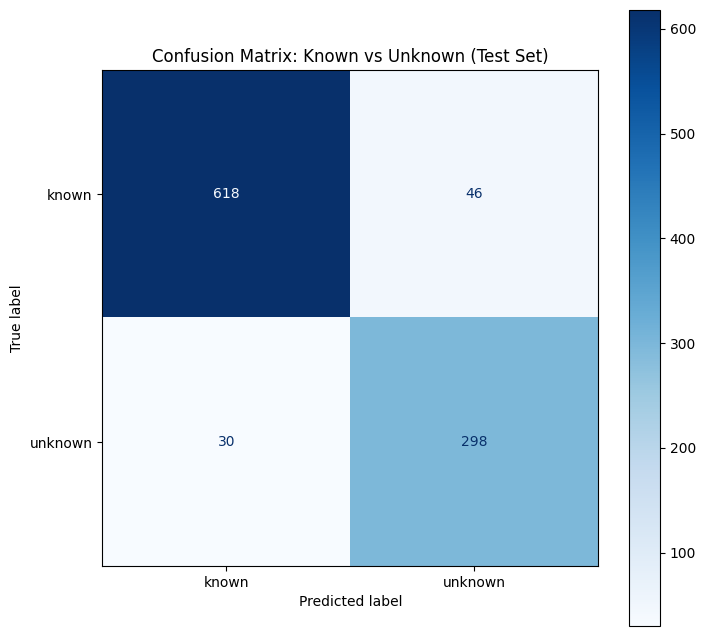

In [ ]:
# Create binary labels for known vs unknown
true_binary = ['known' if label in known_classes else 'unknown' for label in true_labels_test]
pred_binary = ['known' if p in known_classes else 'unknown' for p in final_preds]

# Create and display the confusion matrix with binary labels
cm = confusion_matrix(true_binary, pred_binary, labels=['known', 'unknown'])
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['known', 'unknown'])
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Known vs Unknown (Test Set)")
plt.show()

In [ ]:
# Assuming 'final_preds', 'true_labels_test', 'test_paths', and 'known_classes' are already computed.
# `known_classes` should be a set or list of all your known class names.

print("\n--- Known vs Unknown Misclassified Images with Details ---")
print("Image Path | Correct Label | Predicted Label | Error Type")
print("-------------------------------------------------------------------")

# Create a list to store misclassified details
misclassified_details_binary = []

for i in range(len(final_preds)):
    true_label = true_labels_test[i]
    pred_label = final_preds[i]

    is_true_known = true_label in known_classes
    is_pred_known = pred_label in known_classes

    # Check for misclassification between known and unknown
    # This happens in two cases:
    # 1. True label is known, but predicted label is unknown (False Negative)
    # 2. True label is unknown, but predicted label is known (False Positive)
    if is_true_known != is_pred_known:
        error_type = ""
        if is_true_known and not is_pred_known:
            error_type = "known -> unknown (False Negative)"
        elif not is_true_known and is_pred_known:
            error_type = "unknown -> known (False Positive)"

        misclassified_details_binary.append({
            'path': test_paths[i],
            'correct': true_label,
            'predicted': pred_label,
            'error_type': error_type
        })

# Print the detailed list of misclassified images
if misclassified_details_binary:
    num = 1
    for item in misclassified_details_binary:
        print(f"{num} {item['path'][40:]} | {item['correct']} | {item['predicted']} | {item['error_type']}")
        num += 1
else:
    print("None found.")


--- Known vs Unknown Misclassified Images with Details ---
Image Path | Correct Label | Predicted Label | Error Type
-------------------------------------------------------------------
1 cattle_1300_DJI_0199.jpg | cattle_1300 | unknown | known -> unknown (False Negative)
2 cattle_1700_DSCF7426.jpg | cattle_1700 | unknown | known -> unknown (False Negative)
3 cattle_2000_DSCF8471.jpg | unknown | cattle_2100 | unknown -> known (False Positive)
4 cattle_2000_DSCF8494.jpg | unknown | cattle_8095 | unknown -> known (False Positive)
5 cattle_2220_DSCF1702.jpg | unknown | cattle_3100 | unknown -> known (False Positive)
6 cattle_2220_DSCF1705.jpg | unknown | cattle_3100 | unknown -> known (False Positive)
7 cattle_4369_DSCF6750.jpg | cattle_4369 | unknown | known -> unknown (False Negative)
8 cattle_4399_DSCF6865.jpg | cattle_4399 | unknown | known -> unknown (False Negative)
9 cattle_4399_DSCF6867.jpg | cattle_4399 | unknown | known -> unknown (False Negative)
10 cattle_4421_DSCF8139.jpg | c

--- Starting Final Evaluation (Per-Cow Prediction) ---


🔍 Optimizing Threshold: 100%|██████████| 200/200 [00:00<00:00, 583.28it/s]


✅ Best Threshold (optimized for minimizing FP+FN on Val): -0.0368


🗳️ Aggregating per-cow predictions: 100%|██████████| 268/268 [00:00<00:00, 8814.95it/s]



📊 Final Test Results (Per-Cow):
Acc = 0.8731343283582089


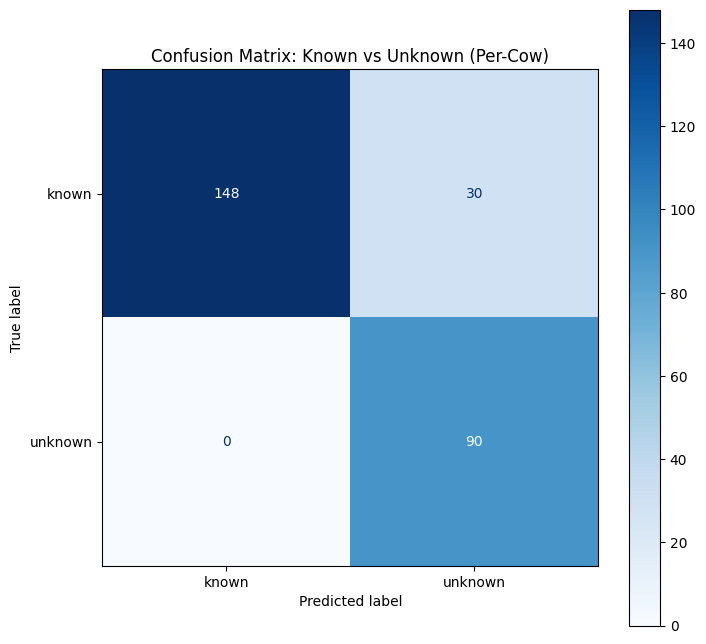

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import os
from tqdm import tqdm

print("--- Starting Final Evaluation (Per-Cow Prediction) ---")

# Assuming embeddings and labels are already loaded
# known_embeddings_norm = normalize_embeddings(known_embeddings).cpu().numpy()
# val_embeddings_norm = normalize_embeddings(val_embeddings).cpu().numpy()
# test_embeddings_norm = normalize_embeddings(test_embeddings).cpu().numpy()

# 1. Optimize Threshold on Validation Set (unchanged from previous step)
knn = NearestNeighbors(n_neighbors=1, metric='cosine')
knn.fit(known_embeddings_norm)

val_true_labels = np.array([label if label in known_classes else 'unknown' for label in val_labels])
val_dists, _ = knn.kneighbors(val_embeddings_norm)
val_scores = -val_dists.min(axis=1)

threshold_range = np.linspace(min(val_scores), max(val_scores), 200)
min_total_errors = float('inf')
best_thr = 0

for thr in tqdm(threshold_range, desc="🔍 Optimizing Threshold"):
    val_pred_labels = np.where(val_scores > thr, 'known', 'unknown')
    cm = confusion_matrix(val_true_labels, val_pred_labels, labels=['known', 'unknown'])
    tn, fp, fn, tp = cm.ravel()
    total_errors = fp + fn
    if total_errors < min_total_errors:
        min_total_errors = total_errors
        best_thr = thr

print(f"✅ Best Threshold (optimized for minimizing FP+FN on Val): {best_thr:.4f}")

# 2. Per-Cow Prediction on Test Set
test_dists, test_indices = knn.kneighbors(test_embeddings_norm)
image_preds = []
for dists, indices in zip(test_dists, test_indices):
    min_score = -dists.min()
    if min_score >= best_thr:
        closest_neighbor_idx = indices[dists.argmin()]
        predicted_label = known_labels[closest_neighbor_idx]
    else:
        predicted_label = "unknown"
    image_preds.append(predicted_label)

# 3. Aggregate predictions per cow (majority vote)
unique_test_labels = list(set(test_labels))
final_cow_preds = []
final_cow_true_labels = []

for cow_id in tqdm(unique_test_labels, desc="🗳️ Aggregating per-cow predictions"):
    cow_indices = [i for i, label in enumerate(test_labels) if label == cow_id]
    cow_image_preds = [image_preds[i] for i in cow_indices]

    # Get the majority vote. If it's a known cow, the true label is its ID.
    if cow_id in known_classes:
        true_label = cow_id
    else:
        true_label = "unknown"

    # Majority vote
    if cow_image_preds:
        majority_vote = Counter(cow_image_preds).most_common(1)[0][0]
        final_cow_preds.append(majority_vote)
        final_cow_true_labels.append(true_label)

# 4. Final evaluation with per-cow results
print("\n📊 Final Test Results (Per-Cow):")
print("Acc =", accuracy_score(final_cow_true_labels, final_cow_preds))

# Create binary labels for known vs unknown for the confusion matrix
true_binary_cows = ['known' if label in known_classes else 'unknown' for label in final_cow_true_labels]
pred_binary_cows = ['known' if p in known_classes else 'unknown' for p in final_cow_preds]

# Compute and display the confusion matrix
cm = confusion_matrix(true_binary_cows, pred_binary_cows, labels=['known', 'unknown'])
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['known', 'unknown'])
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Known vs Unknown (Per-Cow)")
plt.show()